
===== CLEANED DATA =====
        Date         DJIA  FTSE100       CAC40
0 2009-08-06  16090.17457  2929.07  6560.50517
1 2009-08-07  16288.02074  2954.69  6642.19415
2 2009-08-10  16232.18766  2948.84  6610.88828
3 2009-08-11  16069.88812  2917.08  6519.66241
4 2009-08-12  16287.93145  2950.90  6615.98017 

===== FIRST 10 PORTFOLIO LOSSES =====
[-112.77964335   33.79070165  113.70351478 -133.37540352  -54.91370395
   83.63932188  186.43409919  -90.11830607  -37.89558613 -121.17299282] 

===== HISTORICAL SIMULATION RESULTS =====
Portfolio VaR99: 266.02, ES99: 387.86
DJIA     VaR99: 113.43, ES99: 172.62
FTSE100  VaR99: 84.96, ES99: 115.16
CAC40    VaR99: 107.35, ES99: 141.11

===== WEIGHTED HISTORICAL SIMULATION (Hull 13.3.1) =====
Check: sum of weights = 1.000000

===== FIRST 10 WEIGHTED LOSSES (worst to best) =====
          Loss        Weight  CumWeight
0  1092.301662  2.768846e-06   0.000003
1   809.732254  2.796744e-06   0.000006
2   792.898760  2.727521e-06   0.000008
3   551.5930

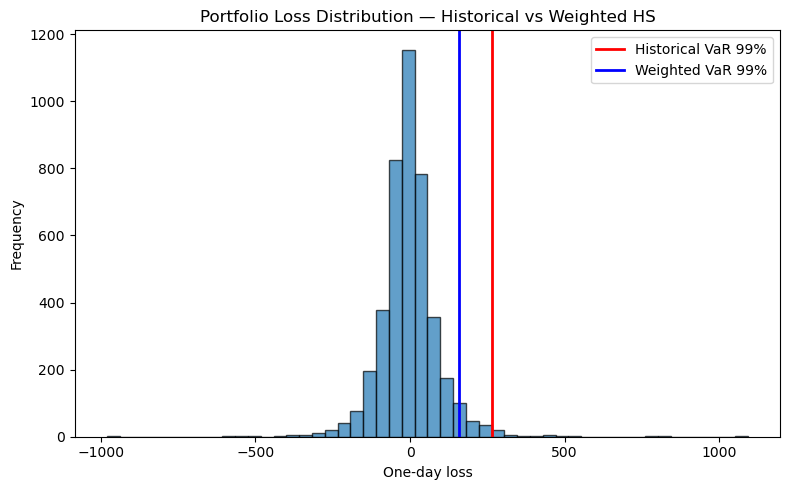

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# LOAD AND CLEAN DATA
# ============================================

df = pd.read_csv("Data.csv", sep=";", skiprows=5)

df.rename(columns={
    "Unnamed: 0": "Date",
    "Dow Jones Global": "DJIA",
    "FTSE UK": "FTSE100",
    "Euronext": "CAC40"
}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'].astype(str), format="%Y%m%d")

num_cols = ["DJIA", "FTSE100", "CAC40"]
for c in num_cols:
    df[c] = df[c].astype(str).str.replace(",", ".", regex=False).astype(float)

print("\n===== CLEANED DATA =====")
print(df.head(), "\n")


# ============================================
# PORTFOLIO SETUP
# ============================================

today_levels = df.loc[len(df) - 1, ["DJIA", "FTSE100", "CAC40"]]

V_DJIA = 4000.0
V_FTSE = 3000.0
V_CAC  = 3000.0
V0_port = V_DJIA + V_FTSE + V_CAC

n_days = len(df)

port_losses = []
djia_losses = []
ftse_losses = []
cac_losses  = []


# ============================================
# PART 1 — STANDARD HISTORICAL SIMULATION
# ============================================

for i in range(1, n_days):

    prev = df.loc[i - 1, ["DJIA", "FTSE100", "CAC40"]]
    curr = df.loc[i,     ["DJIA", "FTSE100", "CAC40"]]

    ratio = curr / prev
    scen_idx = today_levels * ratio

    val_D = V_DJIA * (scen_idx["DJIA"]    / today_levels["DJIA"])
    val_F = V_FTSE * (scen_idx["FTSE100"] / today_levels["FTSE100"])
    val_C = V_CAC  * (scen_idx["CAC40"]   / today_levels["CAC40"])

    V_port_i = val_D + val_F + val_C
    loss_i = V0_port - V_port_i

    port_losses.append(loss_i)
    djia_losses.append(V_DJIA - val_D)
    ftse_losses.append(V_FTSE - val_F)
    cac_losses.append(V_CAC - val_C)

port_losses = np.array(port_losses)
djia_losses = np.array(djia_losses)
ftse_losses = np.array(ftse_losses)
cac_losses  = np.array(cac_losses)

print("===== FIRST 10 PORTFOLIO LOSSES =====")
print(port_losses[:10], "\n")


# ============================================
# VaR & ES Helper
# ============================================
def hull_var_es(losses, alpha=0.99):
    losses = np.asarray(losses)
    worst = np.sort(losses)[::-1]
    m = len(losses)
    k = int(np.ceil((1 - alpha) * m))
    return worst[k - 1], worst[:k - 1].mean()


# ============================================
# PART 2 — RESULTS FOR ASSETS + PORTFOLIO
# ============================================

alpha = 0.99

var_p, es_p = hull_var_es(port_losses, alpha)
var_D, es_D = hull_var_es(djia_losses, alpha)
var_F, es_F = hull_var_es(ftse_losses, alpha)
var_C, es_C = hull_var_es(cac_losses, alpha)

print("===== HISTORICAL SIMULATION RESULTS =====")
print(f"Portfolio VaR99: {var_p:.2f}, ES99: {es_p:.2f}")
print(f"DJIA     VaR99: {var_D:.2f}, ES99: {es_D:.2f}")
print(f"FTSE100  VaR99: {var_F:.2f}, ES99: {es_F:.2f}")
print(f"CAC40    VaR99: {var_C:.2f}, ES99: {es_C:.2f}")
print()


# ============================================
# PART 3 — WEIGHTED HISTORICAL SIMULATION (Hull 13.3.1)
# ============================================

print("===== WEIGHTED HISTORICAL SIMULATION (Hull 13.3.1) =====")

# 1) Put losses into a DataFrame in TIME ORDER
df_weighted = pd.DataFrame({'Loss': port_losses})  # port_losses: oldest → newest

# 2) Define exponential time-decay weights (more weight on recent observations)
lambda_ = 0.995
n = len(df_weighted)

# k = 0 (oldest) ... n-1 (most recent)
k = np.arange(n)

# raw weights: largest for most recent (k = n-1)
raw_weights = (1 - lambda_) * lambda_**(n - 1 - k)

# normalise so they sum to 1
weights = raw_weights / raw_weights.sum()
df_weighted['Weight'] = weights

print(f"Check: sum of weights = {df_weighted['Weight'].sum():.6f}")

# 3) Sort by LOSS size (worst → best) to build the weighted tail distribution
df_sorted = df_weighted.sort_values(by='Loss', ascending=False).reset_index(drop=True)
df_sorted['CumWeight'] = df_sorted['Weight'].cumsum()

print("\n===== FIRST 10 WEIGHTED LOSSES (worst to best) =====")
print(df_sorted.head(10), "\n")

# 4) Weighted 99% VaR: smallest loss where cumulative weight ≥ 1%
alpha = 0.99
tail_prob = 1 - alpha  # 0.01

VaR_weighted = df_sorted.loc[df_sorted['CumWeight'] >= tail_prob, 'Loss'].iloc[0]

# 5) Weighted 99% ES: weighted average loss in the worst 1% tail
tail_mask = df_sorted['CumWeight'] <= tail_prob
ES_weighted = (
    (df_sorted.loc[tail_mask, 'Loss'] * df_sorted.loc[tail_mask, 'Weight']).sum()
    / tail_prob
)

print(f"Weighted VaR99 = {VaR_weighted:.2f}")
print(f"Weighted ES99  = {ES_weighted:.2f}")


# ============================================
# PLOT
# ============================================

plt.figure(figsize=(8, 5))
plt.hist(port_losses, bins=50, edgecolor="black", alpha=0.7)
plt.axvline(var_p, color="red", linewidth=2, label="Historical VaR 99%")
plt.axvline(VaR_weighted, color="blue", linewidth=2, label="Weighted VaR 99%")
plt.xlabel("One-day loss")
plt.ylabel("Frequency")
plt.title("Portfolio Loss Distribution — Historical vs Weighted HS")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Current index levels (today = last row, Day n)
today_levels = df.loc[len(df) - 1, ["DJIA", "FTSE100", "CAC40"]]

# Initial portfolio (assignment: 4000, 3000, 3000)
V_DJIA = 4000.0
V_FTSE = 3000.0
V_CAC  = 3000.0
V0_port = V_DJIA + V_FTSE + V_CAC

n_days = len(df)
n_scen = n_days - 1   # scenarios 1 ... n-1

port_losses = []
djia_losses = []
ftse_losses = []
cac_losses  = []

for i in range(1, n_days):
    # levels on day i-1 and day i
    prev = df.loc[i - 1, ["DJIA", "FTSE100", "CAC40"]]
    curr = df.loc[i,     ["DJIA", "FTSE100", "CAC40"]]
    
    # percentage change v_i / v_{i-1}
    ratio = curr / prev
    
    # scenario index levels tomorrow: v_n * (v_i / v_{i-1})
    scen_idx = today_levels * ratio
    
    # revalue each index position under scenario
    val_D = V_DJIA * (scen_idx["DJIA"]    / today_levels["DJIA"])
    val_F = V_FTSE * (scen_idx["FTSE100"] / today_levels["FTSE100"])
    val_C = V_CAC  * (scen_idx["CAC40"]   / today_levels["CAC40"])
    
    # portfolio value and loss
    V_port_i = val_D + val_F + val_C
    loss_i   = V0_port - V_port_i   # positive = loss, negative = gain
    
    port_losses.append(loss_i)
    djia_losses.append(V_DJIA - val_D)
    ftse_losses.append(V_FTSE - val_F)
    cac_losses.append(V_CAC - val_C)

port_losses = np.array(port_losses)
djia_losses = np.array(djia_losses)
ftse_losses = np.array(ftse_losses)
cac_losses  = np.array(cac_losses)


=== Stress scenarios (loss and probability) ===
Scenario 1: loss = 1092.30, prob = 0.500 percent
Scenario 2: loss = 809.73, prob = 0.200 percent
Scenario 3: loss = 792.90, prob = 0.200 percent
Scenario 4: loss = 551.59, prob = 0.050 percent
Scenario 5: loss = 534.27, prob = 0.050 percent

=== Stressed distribution (historical plus stress scenarios) ===
Stressed 1 day 99 percent VaR = 551.59
Stressed 1 day 99 percent ES  = 948.81


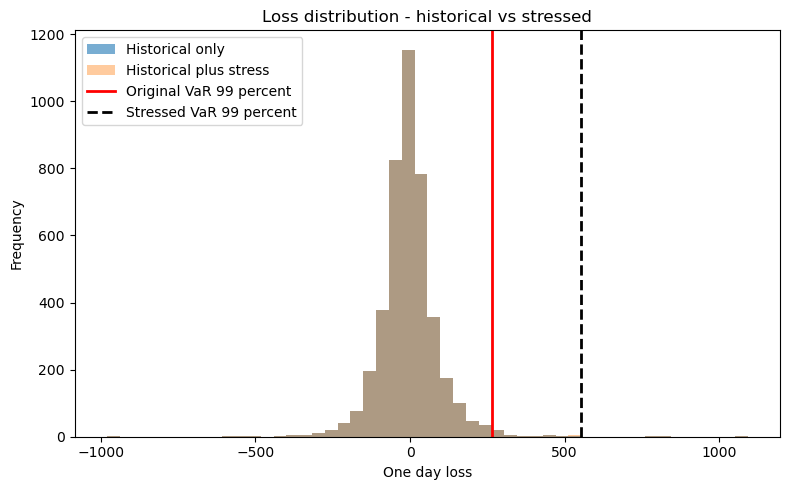

In [12]:
# five worst historical losses for the portfolio
sorted_losses_desc = np.sort(port_losses)[::-1]  # worst to best
stress_losses = sorted_losses_desc[:5]

# given probabilities for stress scenarios
stress_probs = np.array([0.005, 0.002, 0.002, 0.0005, 0.0005])
p_stress_sum = stress_probs.sum()

print("\n=== Stress scenarios (loss and probability) ===")
for i, (L, p) in enumerate(zip(stress_losses, stress_probs), start=1):
    print(f"Scenario {i}: loss = {L:.2f}, prob = {p*100:.3f} percent")

# equal probability for each historical scenario, scaled so that total prob is 1
N = len(port_losses)
p_hist = (1.0 - p_stress_sum) / N
hist_probs = np.full(N, p_hist)

# combine historical and stress scenarios
all_losses = np.concatenate([port_losses, stress_losses])
all_probs  = np.concatenate([hist_probs,  stress_probs])

# sort combined distribution from worst to best
idx_all = np.argsort(all_losses)[::-1]
L_all_sorted = all_losses[idx_all]
p_all_sorted = all_probs[idx_all]
cum_p = np.cumsum(p_all_sorted)

alpha = 0.99
tail_prob = 1 - alpha

# stressed VaR: first loss where cumulative probability reaches at least 1 - alpha
var_stress = L_all_sorted[cum_p >= tail_prob][0]

# stressed ES: probability-weighted average of losses in the worst 1% tail
tail_mask = cum_p <= tail_prob
es_stress = (L_all_sorted[tail_mask] * p_all_sorted[tail_mask]).sum() / p_all_sorted[tail_mask].sum()

print("\n=== Stressed distribution (historical plus stress scenarios) ===")
print(f"Stressed 1 day 99 percent VaR = {var_stress:.2f}")
print(f"Stressed 1 day 99 percent ES  = {es_stress:.2f}")

# optional: plot comparison of original and stressed distributions
plt.figure(figsize=(8, 5))
plt.hist(port_losses, bins=50, alpha=0.6, label="Historical only")
plt.hist(all_losses,  bins=50, alpha=0.4, label="Historical plus stress")
plt.axvline(var_p,        color="red",  linewidth=2, label="Original VaR 99 percent")
plt.axvline(var_stress,   color="black", linewidth=2, linestyle="--", label="Stressed VaR 99 percent")
plt.xlabel("One day loss")
plt.ylabel("Frequency")
plt.title("Loss distribution - historical vs stressed")
plt.legend()
plt.tight_layout()
plt.show()


=== Bootstrap CI for 1 day 99 percent VaR ===
Original HS VaR99         = 266.02
Bootstrap 95 percent CI   = [248.71, 287.09]


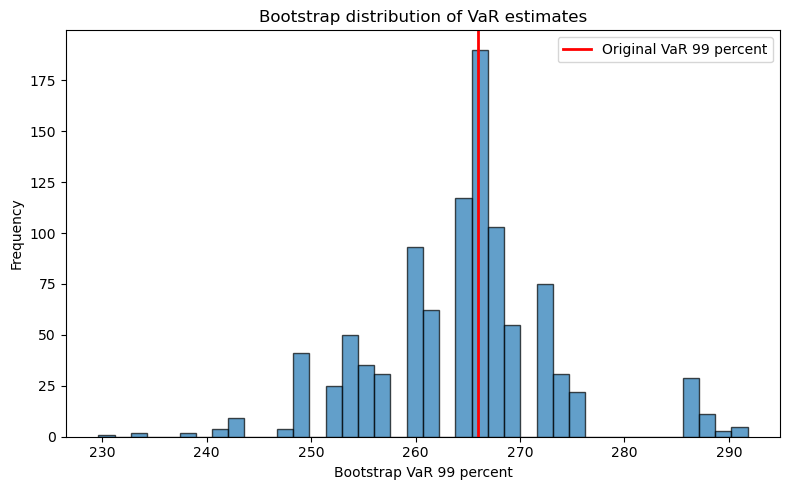

In [13]:
# ============================
# PART 2.2 - Bootstrap CI for VaR
# ============================

def hull_var_only(losses, alpha=0.99):
    """Hull style historical VaR - k-th worst loss."""
    losses = np.asarray(losses)
    m = len(losses)
    worst = np.sort(losses)[::-1]
    k = int(np.ceil((1 - alpha) * m))
    return worst[k - 1]

alpha = 0.99
orig_var = hull_var_only(port_losses, alpha=alpha)

rng = np.random.default_rng(42)  # fixed seed for reproducibility
B = 1000                         # number of bootstrap samples
n = len(port_losses)

boot_vars = np.empty(B)

for b in range(B):
    sample = rng.choice(port_losses, size=n, replace=True)
    boot_vars[b] = hull_var_only(sample, alpha=alpha)

ci_low, ci_high = np.quantile(boot_vars, [0.025, 0.975])

print("\n=== Bootstrap CI for 1 day 99 percent VaR ===")
print(f"Original HS VaR99         = {orig_var:.2f}")
print(f"Bootstrap 95 percent CI   = [{ci_low:.2f}, {ci_high:.2f}]")

# optional: plot distribution of bootstrap VaRs
plt.figure(figsize=(8, 5))
plt.hist(boot_vars, bins=40, edgecolor="black", alpha=0.7)
plt.axvline(orig_var, color="red", linewidth=2, label="Original VaR 99 percent")
plt.xlabel("Bootstrap VaR 99 percent")
plt.ylabel("Frequency")
plt.title("Bootstrap distribution of VaR estimates")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
from scipy.stats import norm

# ============================
# PART 2.3 - Normal based CI (13.2)
# ============================

q = 0.99
n = len(port_losses)

mu = port_losses.mean()
sigma = port_losses.std(ddof=1)

# normal VaR estimate
z_q = norm.ppf(q)
var_norm = mu + sigma * z_q

# density at x = var_norm
f_x = norm.pdf((var_norm - mu) / sigma) / sigma

# standard error
se = (1.0 / f_x) * np.sqrt(q * (1.0 - q) / n)

ci_norm_low  = var_norm - 1.96 * se
ci_norm_high = var_norm + 1.96 * se

print("\n=== Normal based VaR and 95 percent CI (13.2) ===")
print(f"Normal VaR99 estimate     = {var_norm:.2f}")
print(f"Normal 95 percent CI      = [{ci_norm_low:.2f}, {ci_norm_high:.2f}]")



=== Normal based VaR and 95 percent CI (13.2) ===
Normal VaR99 estimate     = 213.67
Normal 95 percent CI      = [203.16, 224.18]
